##1. Reading combined extracted data
----------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
pd.set_option('display.max_columns', None)   # show all columns

In [3]:
df = pd.read_csv('combined_accidents.csv')
df.head()

,publish_date,content,time_24h,corrected_date,injury_severity,affected_party,car,motorbike,larger_vehicle,primary_accident_type_code,age,ages_after_driven_by,driver_age_min,driver_age_max,location,street,locality,day_of_week_num,rush_hour,rain_today,rain_last_3h,temp_avg,temp_min,temp_max,precip_mm_day,roadworks_nearby,street_had_speed_camera
0,11/12/2024,"A 60-year-old woman residing in Swieqi, at aro...",11:15,11/12/2024,grievous,pedestrian,1,0,0,PED,"['60', '48']",[48],48.0,48.0,"Triq il-Kappella tax-Xagħra, Naxxar",Triq il-Kappella tax-Xagħra,Naxxar,2,0,False,False,14.1,8.9,19.6,0.0,False,False
1,11/12/2024,"Update:Unfortunately, the 54-year-old Englishm...",17:00,11/12/2024,death,motorcyclist,0,1,0,FXOBJ,"['54', '54']",[],54.0,54.0,"Dawret San Pawl, Mellieħa",Dawret San Pawl,Mellieħa,2,1,False,False,14.1,8.9,19.6,0.0,False,True
2,14/12/2024,"A 17-year-old girl, residing in Qormi, yesterd...",17:30,13/12/2024,serious,pedestrian,1,0,0,PED,"['17', '52']",[52],52.0,52.0,"Triq il-Marfa, Mellieha",Triq il-Marfa,Mellieha,6,0,NaN,False,18.8,16.9,21.0,NaN,True,False
3,14/12/2024,"Yesterday, at around (1945hrs), the police wer...",19:45,13/12/2024,minor,driver,1,0,0,COLL,"['50', '29']",[50],50.0,50.0,"Dawret il-Gudja, Gudja",Dawret il-Gudja,Gudja,6,0,NaN,False,18.8,16.9,21.0,NaN,True,False
4,14/12/2024,"Yesterday, at around (1945hrs), the police wer...",19:45,13/12/2024,serious,driver,1,0,0,COLL,"['50', '29']",[50],50.0,50.0,"Dawret il-Gudja, Gudja",Dawret il-Gudja,Gudja,6,0,NaN,False,18.8,16.9,21.0,NaN,True,False


In [4]:
#injuiry severity value counts
df['injury_severity'].value_counts()


#note: no injuries can be grouped together with minor injuries for analysis purposes. Critical and grievous injuries can be also grouped. 
#the grievous castegory is the largest and can be reduced to balance the dataset more.


injury_severity
minor          89
grievous       77
serious        40
death          23
no injuries     2
critical        1
Name: count, dtype: int64

In [5]:
df['injury_severity'] = df['injury_severity'].replace({'no injuries':'minor', 'critical':'death'})
df['injury_severity'].value_counts()

injury_severity
minor       91
grievous    77
serious     40
death       24
Name: count, dtype: int64

<Axes: ylabel='count'>

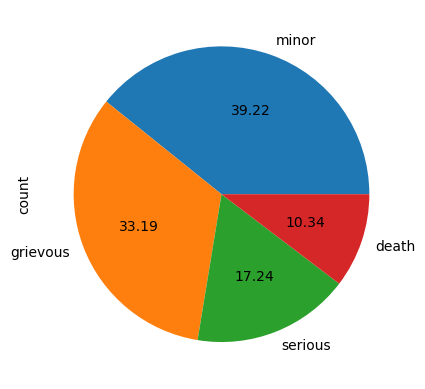

In [6]:
df['injury_severity'].value_counts().plot.pie(autopct='%.2f')

In [7]:
#injuiry severity value counts
df['affected_party'].value_counts()

#note: cyclist and pedestrian can be grouped together

affected_party
driver          113
motorcyclist     75
pedestrian       40
cyclist           4
Name: count, dtype: int64

##1. Injury Severity vs Affected Party
---------------------------------------------------


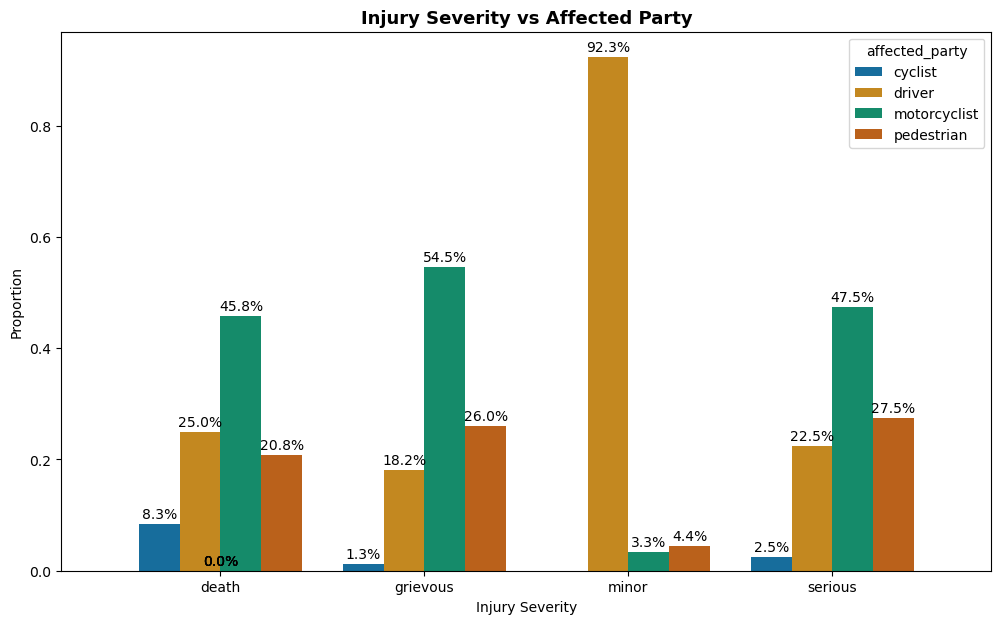

In [8]:
#1. Injury severity vs affected party
grouped_data = df.groupby(['injury_severity', 'affected_party']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('injury_severity')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']


plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="injury_severity", y = "proportion", hue = 'affected_party', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Injury Severity', ylabel='Proportion')

ax.set_title('Injury Severity vs Affected Party', fontsize=13, fontweight='bold')
plt.show()

#motorcyclists are fatalists

The chart reveals that the majority (92%) of minor injury category is occupied by drivers. This is due to the bias in the source and training data, which had very few cases if minor/non-injuries explicitly mentioned. In case of collisions, the sources highlighted the more serious injury often not stating the condition of the other driver involved. This was especially common for reports on collisions between cars and motorcycles, with only motorcyclists' injuries clearly declared. Thus, we assumed that every collision in the source data involved a driver with minor injuries. Although this approach included more cases of minor injuries, the vast majority of them are now associated with drivers.

Around half all serious/grievous/fatal accidents involved motorcyclists.

Part 2. Vehicle Type Score Analysis
-------------------------------------------------------------------

Encoding vehicle types in the following way: 
motorcycle - 1 , 
car - 2, 
larger vehicles - 4.
A sum of the vehicle types is stored in a new column 'vehicle_type_score'
If the sum is 1, it means only a motorcycle was involved, 2 - only car, 3 - a car and a motorcycle or only a larger vehicle, 4 - a larger vehicle and a motorcycle, 5 - all three types

In [9]:
#accident severity vs vehicles involved
#encoding vehicle types in the following way: motorcycle - 1 , car - 2, larger vehicles - 4. A sum of the vehicle types is stored in a new column 'vehicle_type_score'
#  if the sum is 1, it means only a motorcycle was involved, 2 - only a car, 3 - a car and a motorcycle or only a larger vehicle, 4 - a larger vehicle and a motorcycle, 5 - all three types

df['primary_accident_type_code'] = df['primary_accident_type_code'].replace({'LOC':'OTH','ROLL':'OTH','OTHER':'OTH'})

idx_moto = df.loc[(df['affected_party']  == 'motorcyclist') & (df['motorbike'] == 0)].index
df.loc[idx_moto, 'motorbike'] = 1

df['car'] = df['car'].replace({1:2, 0:0})
df['larger_vehicle'] = df['larger_vehicle'].replace({1:4, 0:0})
df['vehicle_type_score'] = df['car'] + df['motorbike'] + df['larger_vehicle'] 
df['primary_accident_type_code'].value_counts()
df['vehicle_type_score'].value_counts()

vehicle_type_score
3    109
2     69
6     20
1     18
7     11
5      3
0      2
Name: count, dtype: int64

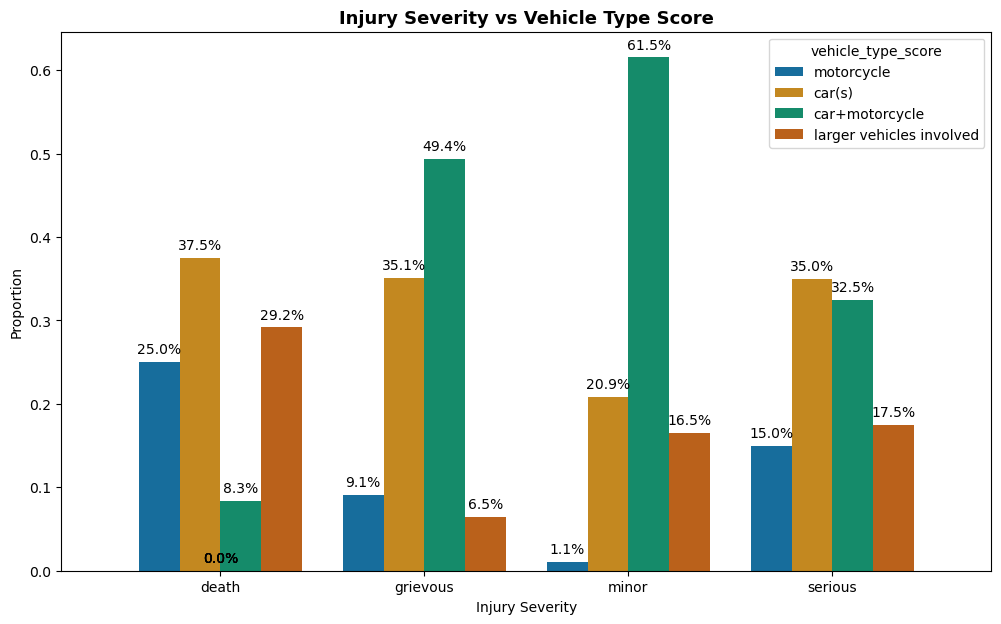

In [10]:
df['vehicle_type_score'] = df['vehicle_type_score'].replace({0:1,1:1,3:3,4:4,5:4,6:4,7:4})
df['vehicle_type_score'].value_counts()

grouped_data = df.groupby(['injury_severity', 'vehicle_type_score']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('injury_severity')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']
grouped_data['vehicle_type_score'] = grouped_data['vehicle_type_score'].replace({1:'motorcycle',2:'car(s)',3:'car+motorcycle',4:'larger vehicles involved'})


plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="injury_severity", y = "proportion", hue = 'vehicle_type_score', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Injury Severity', ylabel='Proportion')

ax.set_title('Injury Severity vs Vehicle Type Score', fontsize=13, fontweight='bold')
plt.show()


Almost one-third of fatalities involved large vehicles. 25% of fatalities were motorcyclists crushing into fixed objects. Only 1% of minor injuries are motorcycles crushed into fixed objects. Over a third of serious/grievous/fatal accidents involved cars.

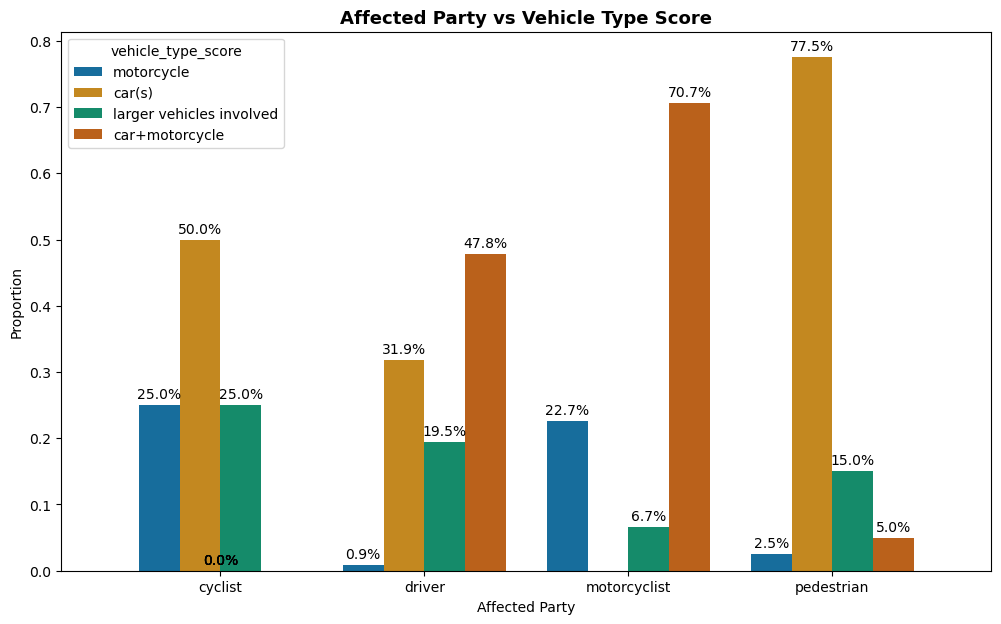

In [11]:
##affected party vs vehicle type score

grouped_data = df.groupby(['affected_party', 'vehicle_type_score']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('affected_party')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']
grouped_data['vehicle_type_score'] = grouped_data['vehicle_type_score'].replace({1:'motorcycle',2:'car(s)',3:'car+motorcycle',4:'larger vehicles involved'})


plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="affected_party", y = "proportion", hue = 'vehicle_type_score', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Affected Party', ylabel='Proportion')

ax.set_title('Affected Party vs Vehicle Type Score', fontsize=13, fontweight='bold')
plt.show()


70% of motorcyclists were injured in collisions with cars, 22% - by crushing into fixed objects. The majority of pedestrians (77.5%) were hit by cars

Part 3. Primary Accident Type Analysis
----------------------------------------------------

In [12]:
df['primary_accident_type_code'] = df['primary_accident_type_code'].replace({'LOC':'OTH','ROLL':'OTH','OTHER':'OTH'})
df['primary_accident_type_code'].value_counts()

primary_accident_type_code
COLL     154
PED       39
FXOBJ     24
OTH       15
Name: count, dtype: int64

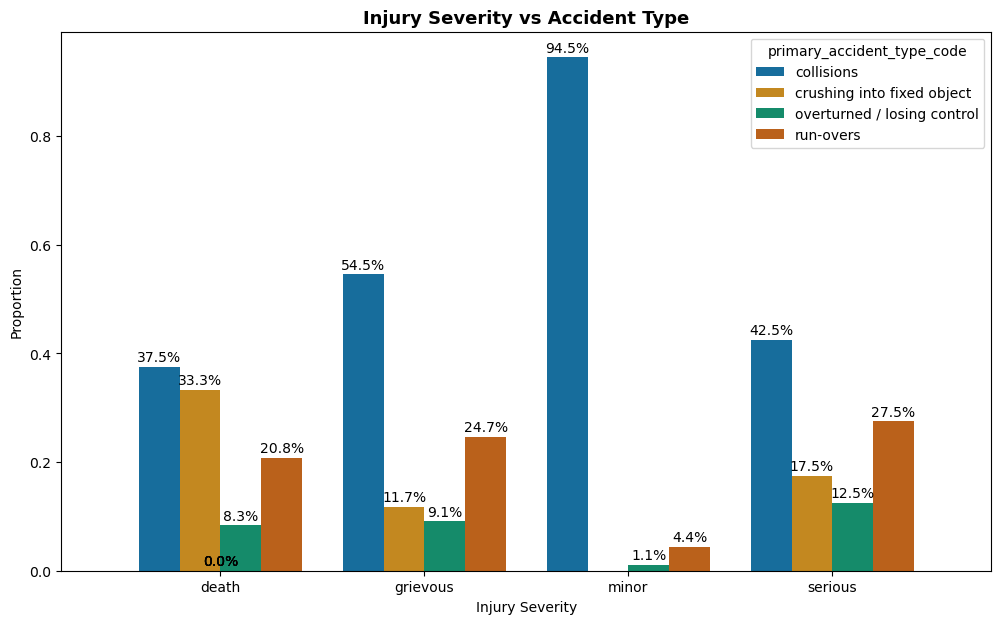

In [13]:
#Injury severity vs primary accident type code

grouped_data = df.groupby(['injury_severity', 'primary_accident_type_code']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('injury_severity')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']
grouped_data['primary_accident_type_code'] = grouped_data['primary_accident_type_code'].replace({'COLL':'collisions','FXOBJ':'crushing into fixed object',
                                                                                         'OTH':'overturned / losing control','PED':'run-overs'})


plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="injury_severity", y = "proportion", hue = 'primary_accident_type_code', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Injury Severity', ylabel='Proportion')

ax.set_title('Injury Severity vs Accident Type', fontsize=13, fontweight='bold')
plt.show()

collisions dominate every injury category, but they are most frequent in minor injuries, which is expected since the data contains multiple records of drivers with minor injuries involved in collisions. Crushing into fixed objects does not lead to minor injuries.

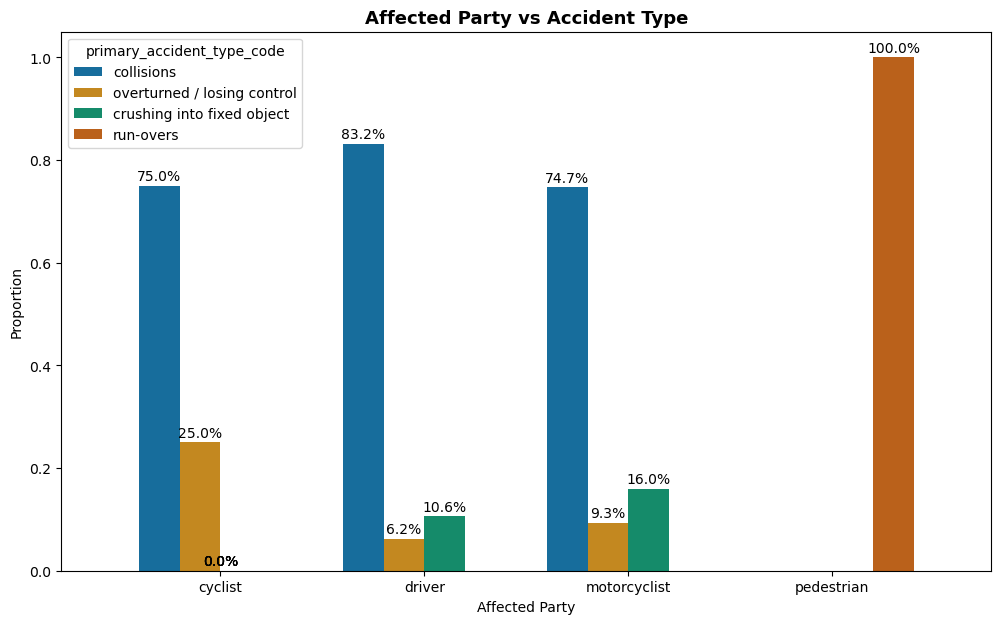

In [14]:
# Affected party vs primary accident type code

#correcting the accident type for pedestrians: all pedestrians are involved only in PED accidents
idx_ped = df.loc[(df['affected_party']  == 'pedestrian') & (df['primary_accident_type_code'] != 'PED')].index
df.loc[idx_ped, 'primary_accident_type_code'] = 'PED'

grouped_data = df.groupby(['affected_party', 'primary_accident_type_code']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('affected_party')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']
grouped_data['primary_accident_type_code'] = grouped_data['primary_accident_type_code'].replace({'COLL':'collisions','FXOBJ':'crushing into fixed object',
                                                                                         'OTH':'overturned / losing control','PED':'run-overs'})

plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="affected_party", y = "proportion", hue = 'primary_accident_type_code', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Affected Party', ylabel='Proportion')

ax.set_title('Affected Party vs Accident Type', fontsize=13, fontweight='bold')
plt.show()

Part 4. Driver Age Analysis
-----------------------------------------------

In [15]:
#introducing an addition driver age parameter:
#if an accident includes a driver under 28yo or over 65yo, the count is 1, otherwise it is 0

df['risky_age'] = ((df['driver_age_min'] <= 28) | 
                   (df['driver_age_max'] >= 65)).astype(int)
df['risky_age']

0      0
1      0
2      0
3      0
4      0
      ..
227    1
228    1
229    1
230    1
231    1
Name: risky_age, Length: 232, dtype: int32

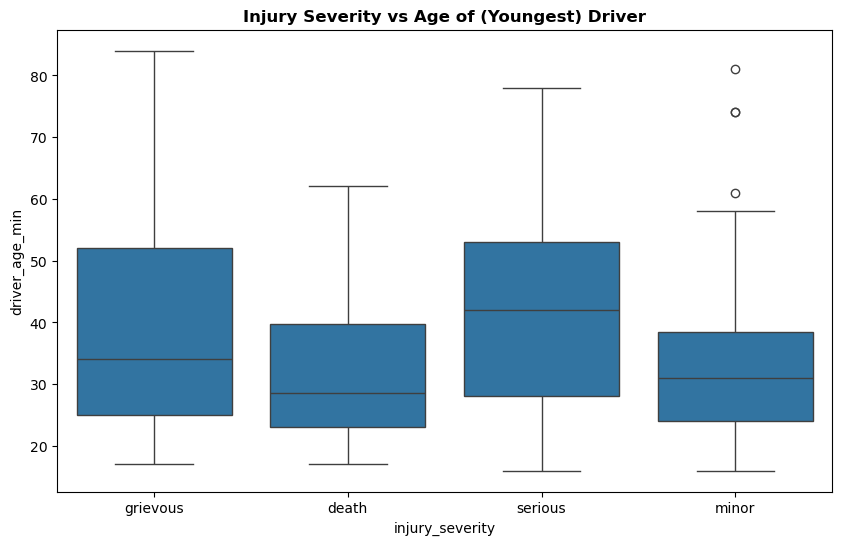

In [16]:
#driver age analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='injury_severity', y='driver_age_min')
ax.set_title('Injury Severity vs Age of (Youngest) Driver', fontsize=12, fontweight='bold')
plt.show()

Fatal injuries involved younger drivers

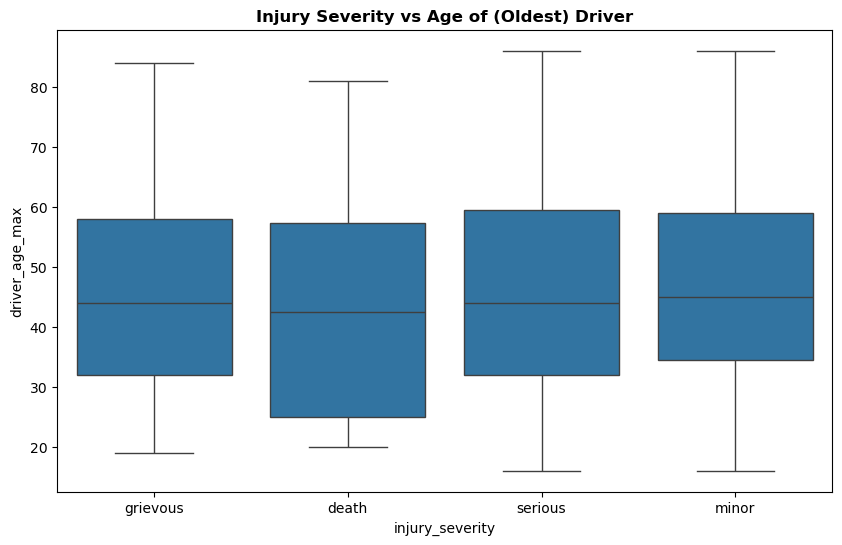

In [17]:
#driver age analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='injury_severity', y='driver_age_max')
ax.set_title('Injury Severity vs Age of (Oldest) Driver', fontsize=12, fontweight='bold')
plt.show()

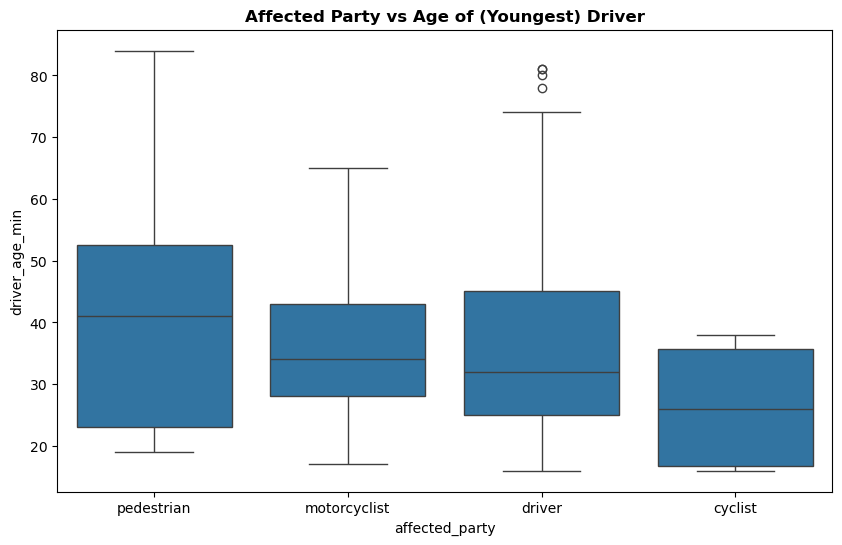

In [18]:
#driver age analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='affected_party', y='driver_age_min')
ax.set_title('Affected Party vs Age of (Youngest) Driver', fontsize=12, fontweight='bold')
plt.show()

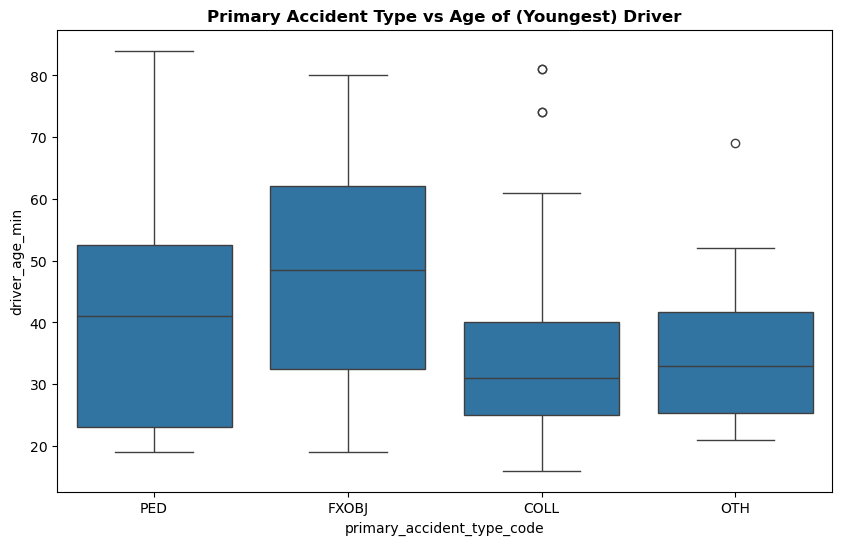

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='primary_accident_type_code', y='driver_age_min')
ax.set_title('Primary Accident Type vs Age of (Youngest) Driver', fontsize=12, fontweight='bold')
plt.show()

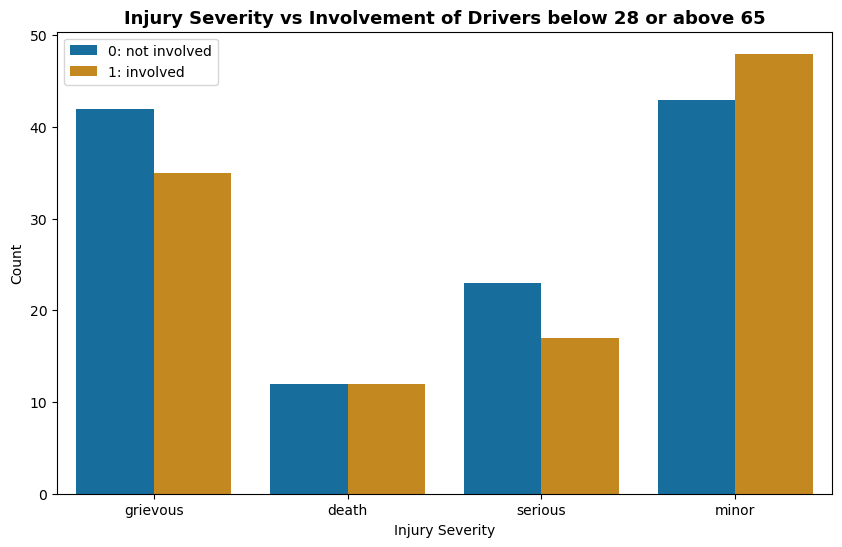

<Figure size 1000x600 with 0 Axes>

In [20]:
#risky age parameter
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="injury_severity", hue = 'risky_age', palette = 'colorblind', data=df)

ax.set(xlabel='Injury Severity', ylabel='Count')
ax.set_title('Injury Severity vs Involvement of Drivers below 28 or above 65', fontsize=13, fontweight='bold')
ax.legend(labels = ['0: not involved', '1: involved'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()

Mean victim age does not add any clarity to the injury severity.

C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\972162635.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['injury_severity', 'age_min_encoded']).size().reset_index(name='counts')
C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\972162635.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  grouped_data['age_min_encoded'] = grouped_data['age_min_encoded'].replace({'1':'under 28','2':'28-45','3':'45-65','4':'over 65'})


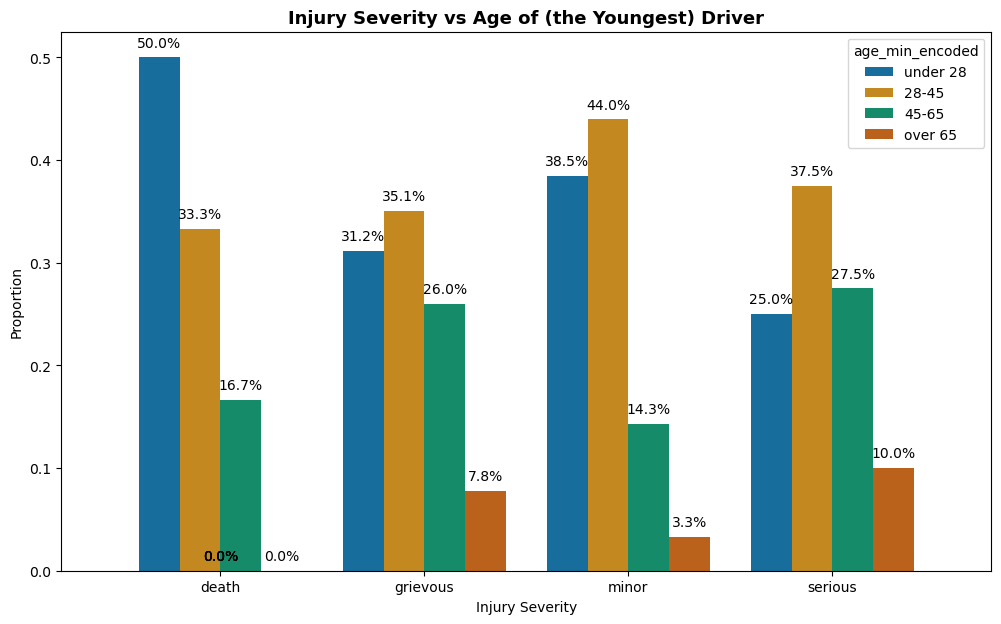

In [21]:
#minimum driver age encoded

df['driver_age_min'] = pd.to_numeric(df['driver_age_min'], errors='coerce')
df['driver_age_min'] = df['driver_age_min'].fillna(df['driver_age_min'].median())

# Define bins and labels (these bins were detected by trying out different age groups and seeing how the graph responds)
bins = [-float('inf'), 28, 45, 65, float('inf')]
labels = ['1', '2', '3', '4']

# Use pd.cut with right=True (<= upper bound), include_lowest=True
bands = pd.cut(df['driver_age_min'], bins=bins, labels=labels, right=True, include_lowest=True)

df['age_min_encoded'] = bands


#driver age analysis
grouped_data = df.groupby(['injury_severity', 'age_min_encoded']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('injury_severity')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']
grouped_data['age_min_encoded'] = grouped_data['age_min_encoded'].replace({'1':'under 28','2':'28-45','3':'45-65','4':'over 65'})

plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="injury_severity", y = "proportion", hue = 'age_min_encoded', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Injury Severity', ylabel='Proportion')

ax.set_title('Injury Severity vs Age of (the Youngest) Driver', fontsize=13, fontweight='bold')
plt.show()



This normilised bar chart reveals that half of drivers involved in fatal accidents were 28 years old or younger.

C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\2642231473.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['primary_accident_type_code', 'age_min_encoded']).size().reset_index(name='counts')
C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\2642231473.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  grouped_data['age_min_encoded'] = grouped_data['age_min_encoded'].replace({'1':'under 28','2':'28-45','3':'45-65','4':'over 65'})


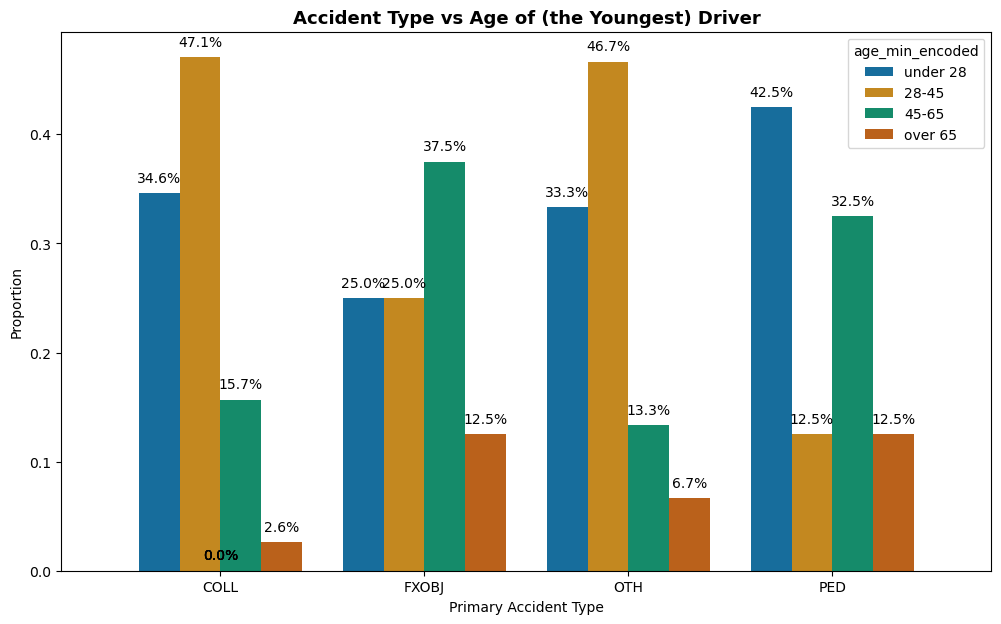

In [22]:
#driver age analysis vs accident type
grouped_data = df.groupby(['primary_accident_type_code', 'age_min_encoded']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('primary_accident_type_code')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']
grouped_data['age_min_encoded'] = grouped_data['age_min_encoded'].replace({'1':'under 28','2':'28-45','3':'45-65','4':'over 65'})

plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="primary_accident_type_code", y = "proportion", hue = 'age_min_encoded', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Primary Accident Type', ylabel='Proportion')

ax.set_title('Accident Type vs Age of (the Youngest) Driver', fontsize=13, fontweight='bold')
plt.show()



Almost half of all collisions between vehicles, losing control and losing control involved drivers between 28 yo and 45 yo. 
Drivers between 45 yo and 65 yo crushed into fixed objects more frequently than other age groups.
Drivers of 28 yo and younger ran over pedestrians more frequently than other age groups.

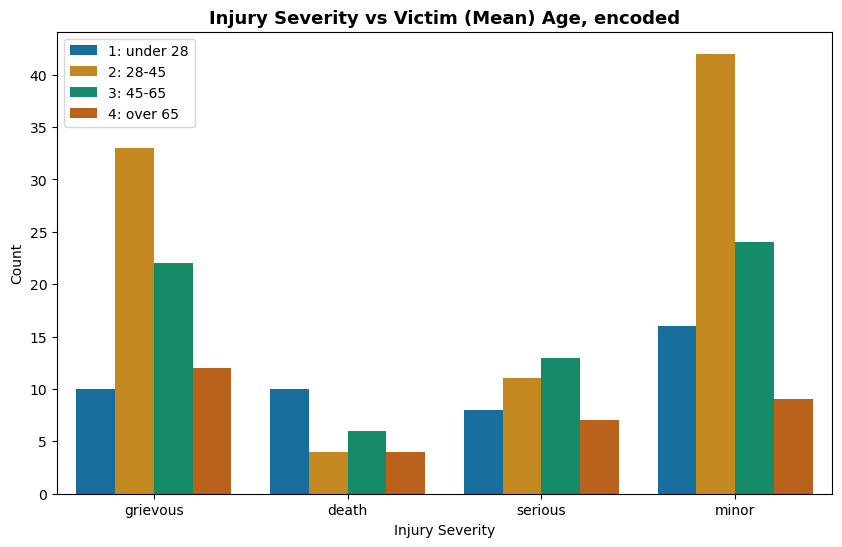

<Figure size 1000x600 with 0 Axes>

In [23]:
#victim ages
import ast  # to safely parse list-like strings
 #Convert "['60','48']" into Python lists
df["age_list"] = df["age"].apply(lambda x: ast.literal_eval(x))

def extract_victim_age(row):
    min_age = row["driver_age_min"]
    max_age = row["driver_age_max"]

    # Loop through the age list in order
    for a in row["age_list"]:
        try:
            age_val = float(a)
        except:
            continue
        
        # If this age is NOT equal to min or max, return it
        if age_val not in (min_age, max_age):
            return age_val
    
    # If all ages = min or max → fallback to driver_age_min
    mean_age = (min_age+max_age)/2
    return mean_age

df['victim_age'] = df.apply(extract_victim_age, axis=1)

# Define bins and labels (these bins were detected by trying out different age groups and seeing how the graph responds)
bins = [-float('inf'), 28, 45, 65, float('inf')]
labels = ['1', '2', '3', '4']

# Use pd.cut with right=True (<= upper bound), include_lowest=True
bands = pd.cut(df['victim_age'], bins=bins, labels=labels, right=True, include_lowest=True)

df['victim_age_encoded'] = bands

#driver age analysis
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="injury_severity", hue = 'victim_age_encoded', palette = 'colorblind', data=df)

ax.set(xlabel='Injury Severity', ylabel='Count')
ax.set_title('Injury Severity vs Victim (Mean) Age, encoded', fontsize=13, fontweight='bold')
ax.legend(labels = ['1: under 28', '2: 28-45', '3: 45-65', '4: over 65'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()





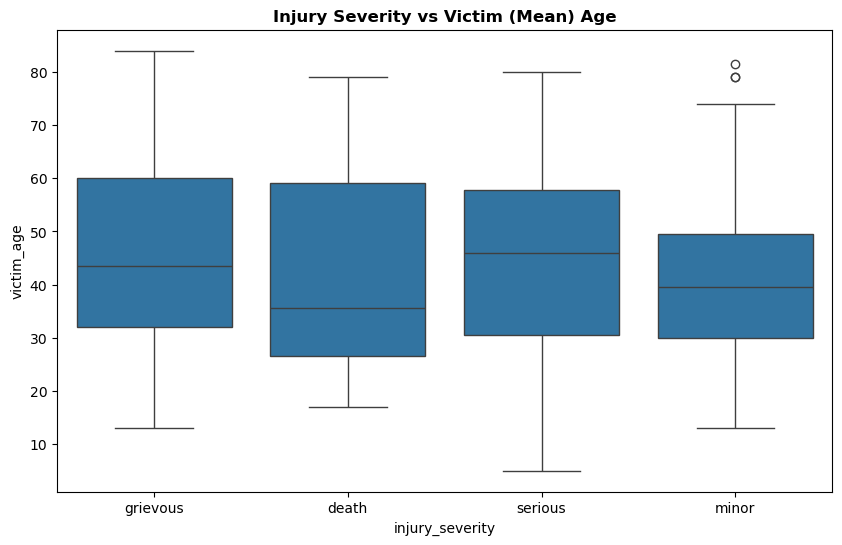

In [24]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='injury_severity', y='victim_age')
ax.set_title('Injury Severity vs Victim (Mean) Age', fontsize=12, fontweight='bold')
plt.show()

No distinct patterns in Victim Mean Age feature, so it will not be used for training the models.

Part 5. Time of the Day Analysis
-----------------------------------------------------------------------


In [25]:
df['hour'] = pd.to_datetime(df['time_24h'], format='%H:%M', errors='coerce').dt.hour
display(df['hour'])

0      11
1      17
2      17
3      19
4      19
       ..
227     9
228     9
229     9
230     9
231     9
Name: hour, Length: 232, dtype: int32

In [26]:
## The time-of-day categories were created using the cut method
df['time_period'] = pd.cut(
    df['hour'],
    bins=[0, 6, 12, 17, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    right=False
)

In [27]:
df.drop(columns=['hour'], inplace=True)
print(df[['time_24h', 'time_period']].head())

  time_24h time_period
0    11:15     Morning
1    17:00     Evening
2    17:30     Evening
3    19:45     Evening
4    19:45     Evening


In [28]:
## Time Period Value Counts
df['time_period'].value_counts()

time_period
Morning      81
Evening      73
Afternoon    54
Night        24
Name: count, dtype: int64

C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\4049694081.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['midnight-6am','6am-noon','noon-5pm','5pm-midnight'])


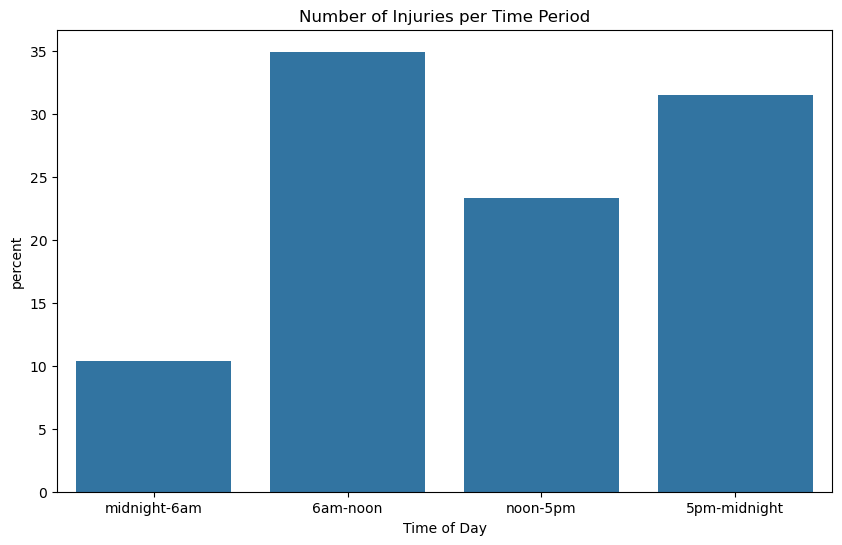

In [29]:
## Time Period Analysis
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='time_period', stat="percent")
plt.xlabel('Time of Day')
plt.title('Number of Injuries per Time Period')
ax.set_xticklabels(['midnight-6am','6am-noon','noon-5pm','5pm-midnight'])
plt.show()

C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\1426688646.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['time_period', 'injury_severity']).size().reset_index(name='counts')
C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\1426688646.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data['total'] = grouped_data.groupby('time_period')['counts'].transform('sum')
C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\1426688646.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  

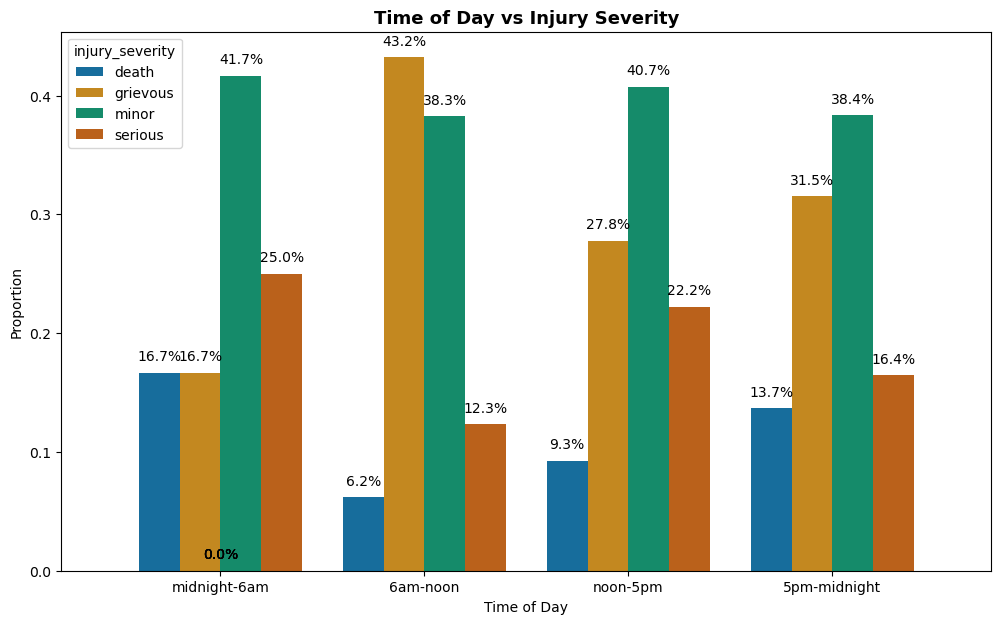

In [30]:
#Injury Severity vs Time of Day

grouped_data = df.groupby(['time_period', 'injury_severity']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('time_period')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']

plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="time_period", y = "proportion", hue = 'injury_severity', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Time of Day', ylabel='Proportion')
ax.set_xticklabels(['midnight-6am','6am-noon','noon-5pm','5pm-midnight'])
ax.set_title('Time of Day vs Injury Severity', fontsize=13, fontweight='bold')
plt.show()



The majority of injuries (43%) between 6am and noon were grievous. The majority of injuries during the rest of the day were minor.

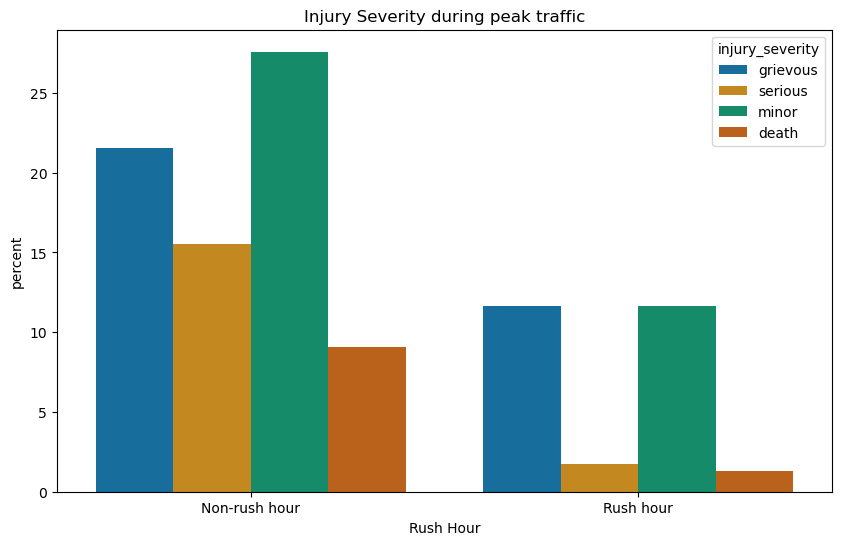

In [31]:
## Evaluating Injury Severity During Peak Traffic
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rush_hour', hue='injury_severity', stat="percent", palette = 'colorblind',)
plt.xticks([0, 1], ['Non-rush hour', 'Rush hour'])
plt.xlabel('Rush Hour')
plt.title('Injury Severity during peak traffic')
plt.show()

Minor injuries are more frequent outside rush hours.

C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\4029219906.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['time_period', 'primary_accident_type_code']).size().reset_index(name='counts')
C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\4029219906.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data['total'] = grouped_data.groupby('time_period')['counts'].transform('sum')
C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\4029219906.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fixed

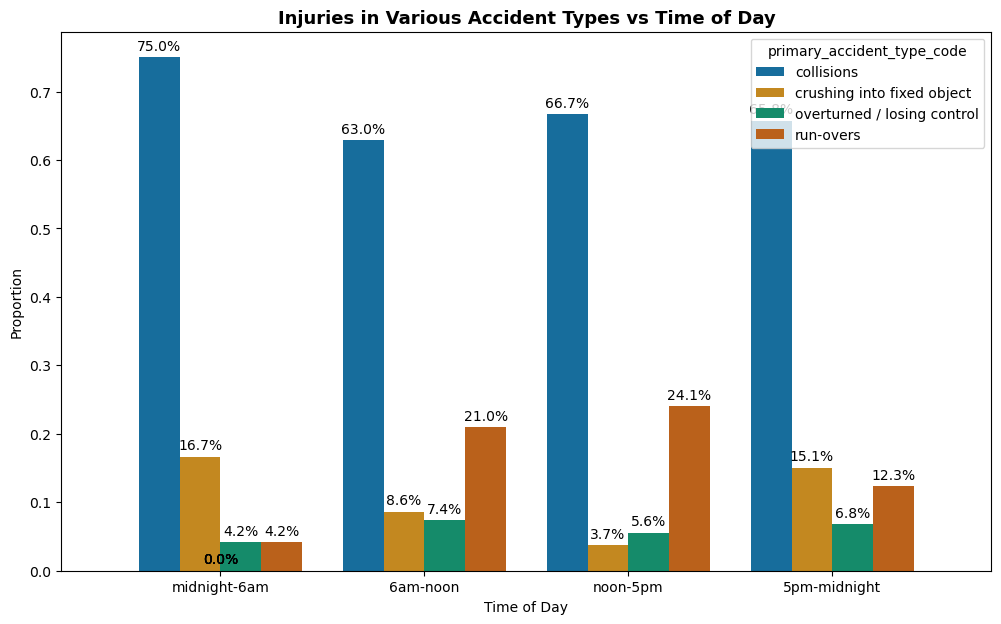

In [32]:
#Injuries in Various Accident Types vs Time of Day

grouped_data = df.groupby(['time_period', 'primary_accident_type_code']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('time_period')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']
grouped_data['primary_accident_type_code'] = grouped_data['primary_accident_type_code'].replace({'COLL':'collisions','FXOBJ':'crushing into fixed object',
                                                                                         'OTH':'overturned / losing control','PED':'run-overs'})

plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="time_period", y = "proportion", hue = 'primary_accident_type_code', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Time of Day', ylabel='Proportion')
ax.set_xticklabels(['midnight-6am','6am-noon','noon-5pm','5pm-midnight'])
ax.set_title('Injuries in Various Accident Types vs Time of Day', fontsize=13, fontweight='bold')
plt.show()



Injuries due to collisions between vehicles were most frequent throught the day. The frequency of run-overs between noon and 5pm was higher compared to the rest of the day.

Part 6. Day of Week Analysis
---------------------------------------------

C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\1454532403.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])


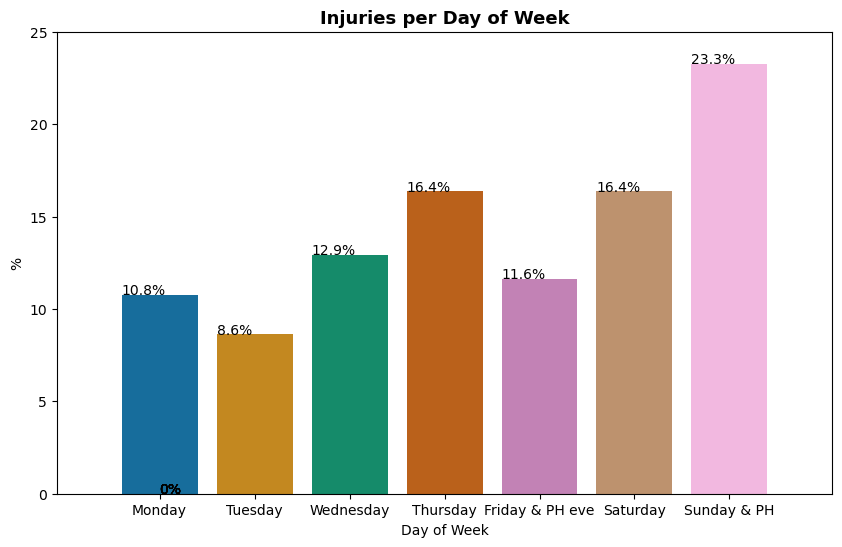

<Figure size 1000x600 with 0 Axes>

In [33]:
#day of week analysis
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="day_of_week_num", hue = 'day_of_week_num', stat="percent", palette = 'colorblind', data=df)

ax.set_ylim(0,25)

# Loop through each bar in the graph and add the percentage value    
for p in ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)


ax.margins(x=0.1)
ax.set(xlabel='Day of Week', ylabel='%')
ax.set_title('Injuries per Day of Week', fontsize=13, fontweight='bold')
ax.legend_.remove()
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])
plt.figure(figsize=(10, 6))
plt.show()


The majority of injuries (23%) occured on Sundays and public holidays. Tuesdays had the lowest number of injuries.

C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\801465019.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])


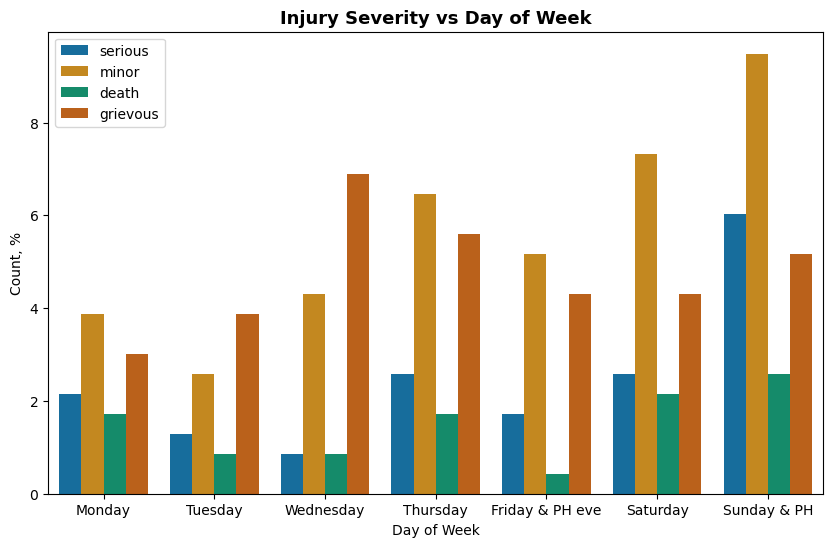

<Figure size 1000x600 with 0 Axes>

In [34]:
#5. Injury severity vs day of the week

plt.figure(figsize=(10, 6))
ax=sns.countplot(x="day_of_week_num", hue = 'injury_severity', stat="percent", palette = 'colorblind', data=df)

ax.set(xlabel='Day of Week', ylabel='Count, %')
ax.set_title('Injury Severity vs Day of Week', fontsize=13, fontweight='bold')
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])
ax.legend( loc='best')
plt.figure(figsize=(10, 6))
plt.show()


C:\Users\galer173\AppData\Local\Temp\ipykernel_33676\3819517483.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])


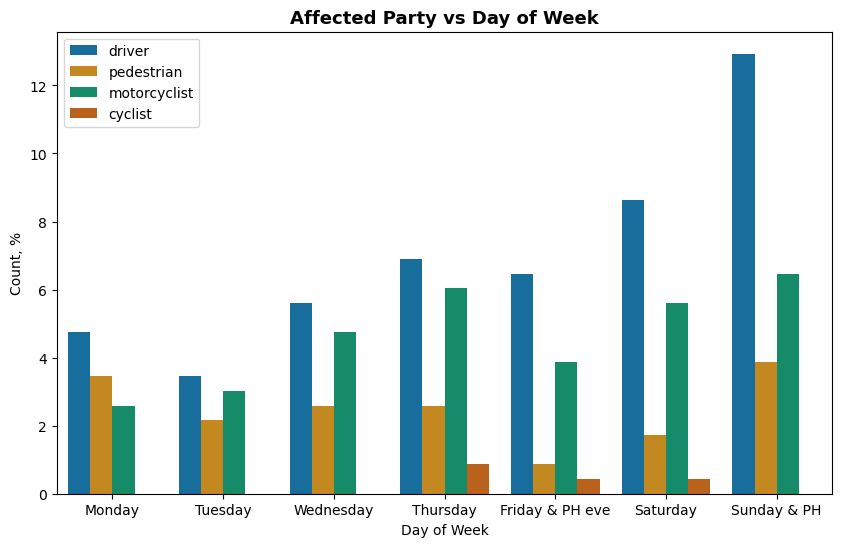

<Figure size 1000x600 with 0 Axes>

In [35]:
#6. Affected party vs day of the week

plt.figure(figsize=(10, 6))
ax=sns.countplot(x='day_of_week_num', hue = 'affected_party', stat="percent", palette = 'colorblind', data=df)

ax.set(xlabel='Day of Week', ylabel='Count, %')
ax.set_title('Affected Party vs Day of Week', fontsize=13, fontweight='bold')
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])
ax.legend(loc='best')
plt.figure(figsize=(10, 6))
plt.show()


Part 7. Weather Analysis
--------------------------------------

In [36]:
#filling nans in rain with booleans

df['rain_today'] = df['rain_today'].fillna(0).astype('bool')
df['rain_last_3h'] = df['rain_last_3h'].fillna(0).astype('bool')

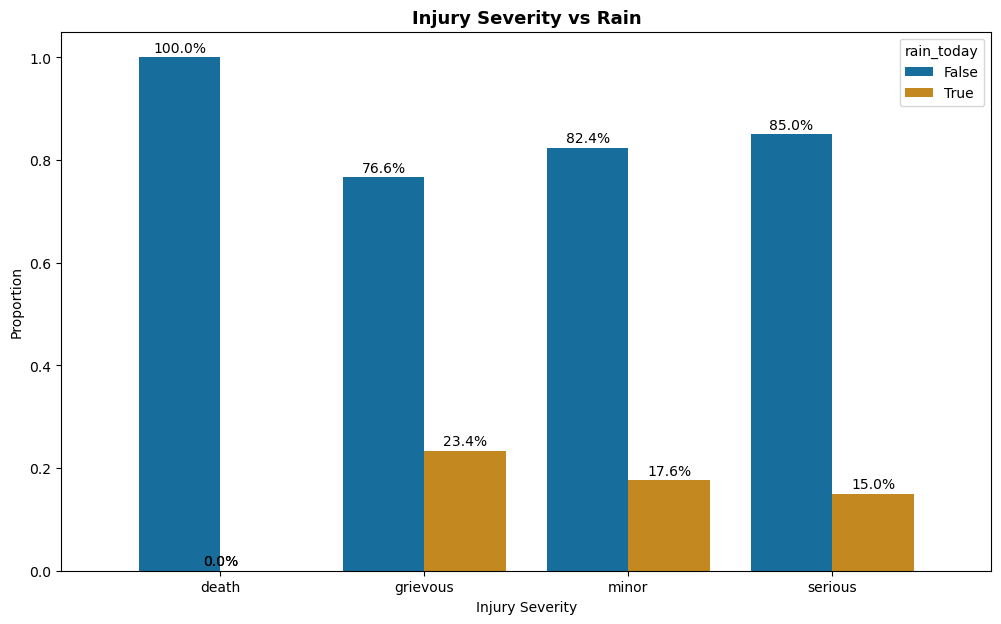

In [37]:
grouped_data = df.groupby(['injury_severity', 'rain_today']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('injury_severity')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']

plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="injury_severity", y = "proportion", hue = 'rain_today', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Injury Severity', ylabel='Proportion')
ax.set_title('Injury Severity vs Rain', fontsize=13, fontweight='bold')
plt.show()

No fatal accidents occured on rainy days.

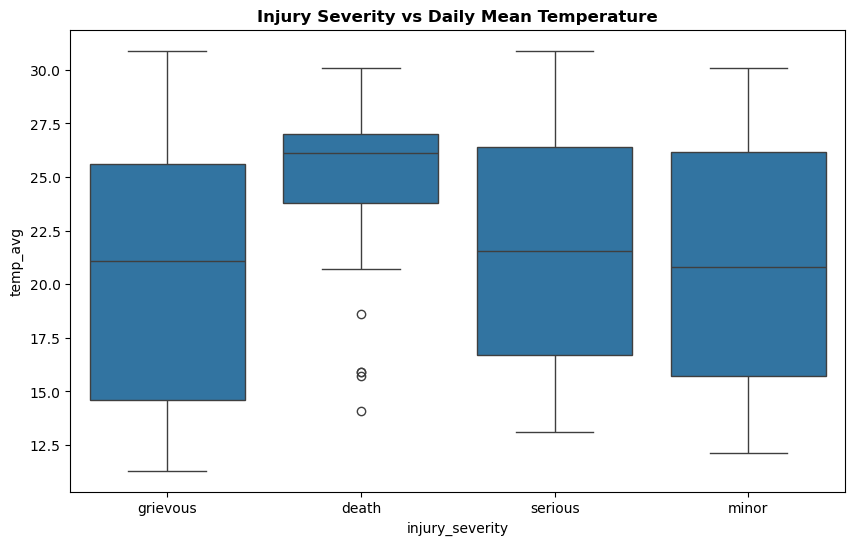

In [38]:
#injury severity vs daily mean temperature
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='injury_severity', y='temp_avg')
ax.set_title('Injury Severity vs Daily Mean Temperature', fontsize=12, fontweight='bold')
plt.show()

Part 8. Injury Severity vs Roadworks and Speed Cameras
------------------------------------------------------------------------------

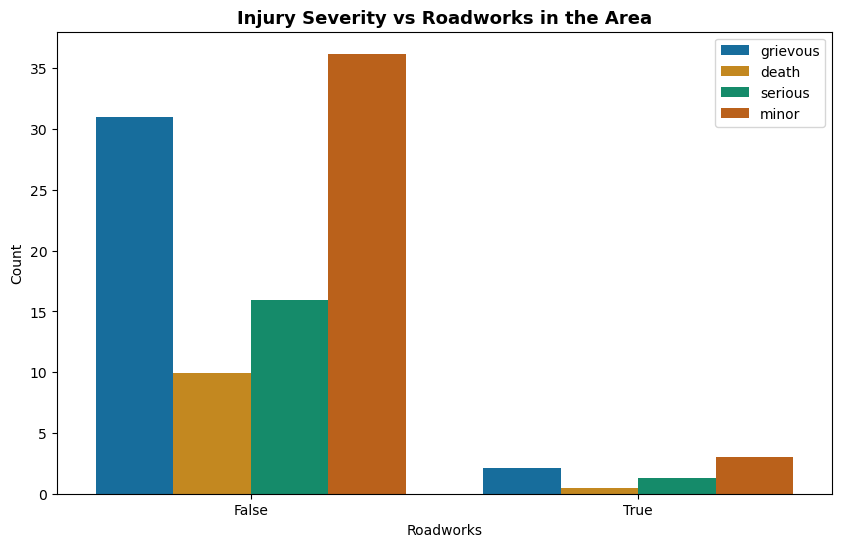

<Figure size 1000x600 with 0 Axes>

In [39]:
#rinjury severity vs roadworks
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="roadworks_nearby", hue = 'injury_severity', stat="percent", palette = 'colorblind', data=df)

ax.set(xlabel='Roadworks', ylabel='Count')
ax.set_title('Injury Severity vs Roadworks in the Area', fontsize=13, fontweight='bold')
ax.legend(loc='best')
plt.figure(figsize=(10, 6))
plt.show()

There are not enough roadwork detections to utilise this feature. 

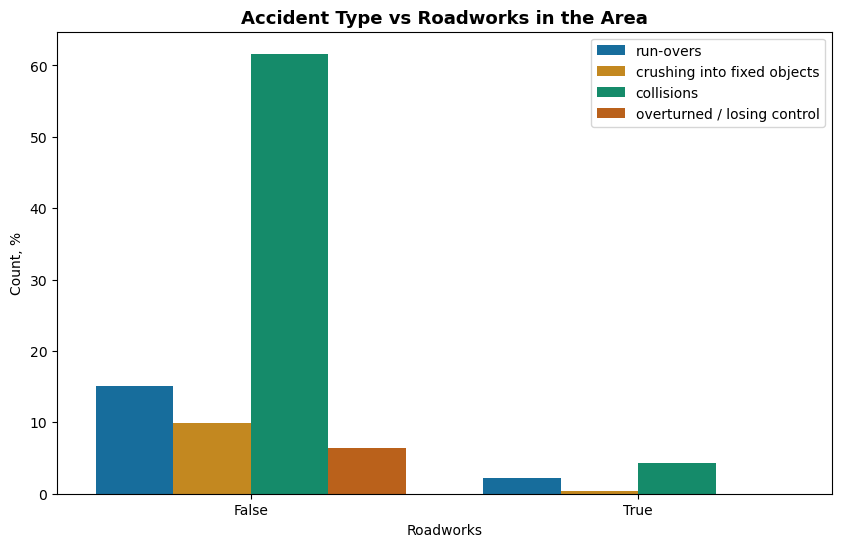

<Figure size 1000x600 with 0 Axes>

In [40]:
#accident type vs roadworks
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="roadworks_nearby", hue = "primary_accident_type_code", stat="percent", palette = 'colorblind', data=df)

ax.set(xlabel='Roadworks', ylabel='Count, %')
ax.set_title('Accident Type vs Roadworks in the Area', fontsize=13, fontweight='bold')
ax.legend(labels = ['run-overs', 'crushing into fixed objects', 'collisions', 'overturned / losing control'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()

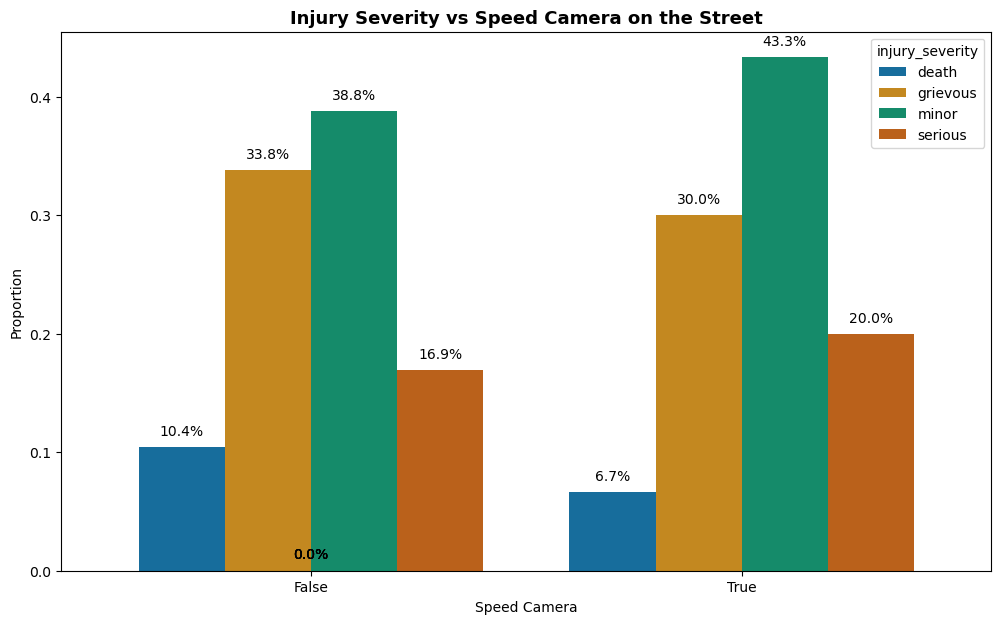

In [41]:
#injury severity vs Speed Cameras
grouped_data = df.groupby(['street_had_speed_camera', 'injury_severity']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('street_had_speed_camera')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']

plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="street_had_speed_camera", y = "proportion", hue = 'injury_severity', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Speed Camera', ylabel='Proportion')
ax.set_title('Injury Severity vs Speed Camera on the Street', fontsize=13, fontweight='bold')
plt.show()

Locations with speed cameras had fewer fatal accidents and more minor injuries, however this is not conclusive since there are only 30 records with speed cameras.

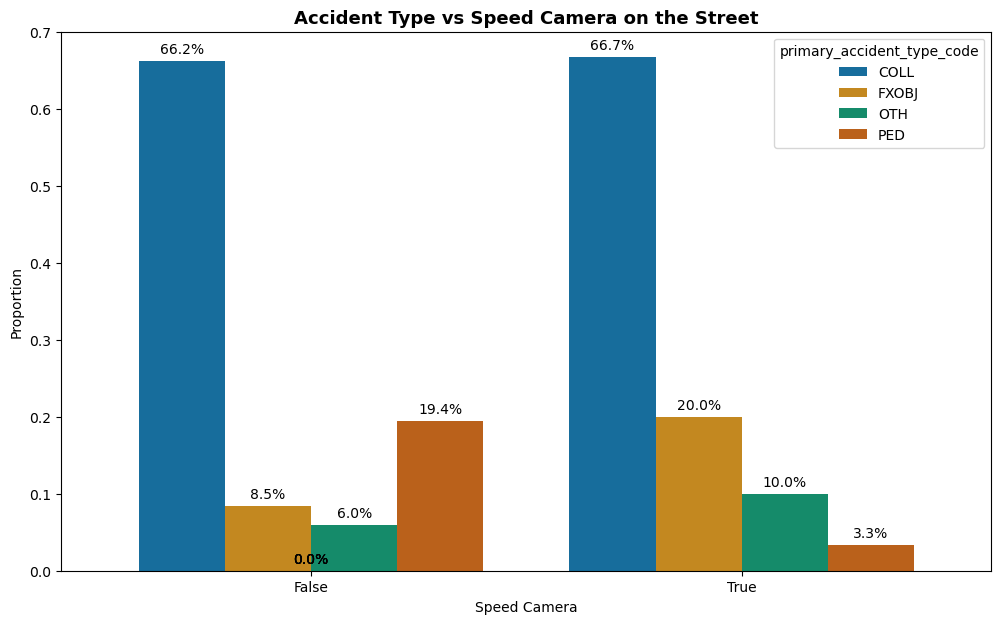

In [42]:
#Accident Type vs Speed Cameras
grouped_data = df.groupby(['street_had_speed_camera', 'primary_accident_type_code']).size().reset_index(name='counts')

# Calculate the total counts for each day
grouped_data['total'] = grouped_data.groupby('street_had_speed_camera')['counts'].transform('sum')

# Calculate the proportion of each category
grouped_data['proportion'] = grouped_data['counts'] / grouped_data['total']

plt.figure(figsize=(12, 7))
#plt.rcParams.update({'font.size':9.5})
ax=sns.barplot(x="street_had_speed_camera", y = "proportion", hue = 'primary_accident_type_code', palette = 'colorblind', data=grouped_data)

# Add percentage labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.01, f'{height:.1%}', ha="center")
ax.margins(x=0.1)

ax.set(xlabel='Speed Camera', ylabel='Proportion')
ax.set_title('Accident Type vs Speed Camera on the Street', fontsize=13, fontweight='bold')
plt.show()


The areas with speed cameras had many fewer pedestrian run-overs. Speed cameras are placed on regional roads with few pedestrian crossings.

the models will predict injury severity, based on the followig parameters:

-affected_party;

-primary_accident_type_code;

-rain_today (no fatalities on rainy days);

-vehicle_type_score (good parameter to classify grievous and minor injuries);

-age_min_encoded (most grievous injuries involve drivers under 28, no fatal accidents involve drivers over 65 );

In [ ]:
#outputting the updated combined file
#writing the output to a csv file
#dropping intermediate columns
df.drop(['car', 'motorbike', 'larger_vehicle', 'driver_age_max','temp_avg', 'temp_min','temp_max','precip_mm_day','risky_age','victim_age','victim_age_encoded', 'age_list'], axis=1, inplace=True)
output_file = "combined_accidents_clean.csv"
df.to_csv(output_file, index=False)